# Synthetic Validation

In order to validate the model, I will create couples from the ML25M database

In [2]:
import gensim
from gensim.models.doc2vec import Doc2Vec
import pandas as pd
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

from tqdm import notebook, tqdm
import math

Load the model and the databases

In [2]:
#load model
directory = '/Users/dbikiel/Documents/Insight-Local/notebooks/'
model = Doc2Vec.load(directory + 'model_doc2vec_20120123')
titles = pd.read_csv('/Users/dbikiel/PycharmProjects/Insight/data/ml-25m/movies.csv')
ratings = pd.read_csv('/Users/dbikiel/PycharmProjects/Insight/data/ml-25m/ratings.csv')
metadata = pd.read_csv('/Users/dbikiel/PycharmProjects/Insight/data/TMDB-metadata-62K.csv')

metadata['movieId'] = titles.movieId

movieid_to_doctags = {int(movie): i for i, movie in enumerate(metadata.movieId)}
movie_set = list(set(ratings['movieId'].values))

I will create help functions to automatize the process of validation. I will first filter the userdatabase to select user with several movies rated, select favourite movies based on ratings, creation of pair of users, check overlaping, recommend based on Ninjas versus Puppies model, quantify the success of the recommendation based on the overlapping and a general function to repeat the process N times.

The comparison of NvP will be against a model which I will call Random Union (r_u). For this model, once I have a pair selected, I will draw at random movies from the union of the sets of both users.

For both models, I will assume a succesfull recommendation if the recommenders suggest movies from the intersection of the sets of both users.

In [34]:
def create_user_list(ratings, N):
    """
    Creates a list with the N users with highest amount of ratings
    """
    return list(ratings['userId'].value_counts().head(N).index)


def create_user_list2(ratings, N):
    """
    Creates a list with the users with at lest N ratings
    """
    return list(ratings['userId'].value_counts()[ratings['userId'].value_counts() > N].index)

def select_favorite_movie(user, ratings):
    """
    Select favourite movie randomly based movies with rating of at least 4.5 over 5
    """
    potential_choices = ratings[(ratings['userId'] == user) & (ratings['rating'] >=  4.5)][['movieId','rating']]
    potential_choices = list(potential_choices['movieId'].values)
    
    # return a random movie with at least a rating of 4.5
    return  np.random.choice(potential_choices, size = 1)[0]

def create_pair_of_users(list_of_users):
    """
    Create random pairs from the list of potential users
    """
    return list(np.random.choice(list_of_users, size = 2, replace = False))

def create_pair_of_users_overlaping(list_of_users, ratings, value):
    """
    Create pair of users if the overlapping is higher than a threshold (value)
    """
    ratio = 1.0
    while ratio > value:
        user_pair = np.random.choice(list_of_users, size = 2, replace = False)
        user1_movies = set(ratings[ratings['userId'] == user_pair[0]]['movieId'].values)
        user2_movies = set(ratings[ratings['userId'] == user_pair[1]]['movieId'].values)
        user1_user2_intersection = user1_movies.intersection(user2_movies)
        user1_user2_union = user1_movies.union(user2_movies)
        ratio = len(user1_user2_intersection)/len(user1_user2_union)
        #print(user_pair, ratio)
    return user_pair 

def movieid_to_title(movieid, titles):
    """
    Returns the titles for each movie Id in the database
    """
    return list(titles.title[titles.movieId == movieid].values)[0]

def movie_filter(movies_df, minvotes = 500, minaverage = 5.0):
    """
    Filters the original data frame to
    :param movies_df: original data
    :param minvotes: minimum votes kept
    :param minaverage: min rating kept
    :return: dataframe of movies filtered
    """
    filtered = movies_df[(movies_df.vote_average >= int(minaverage)) & (movies_df.vote_count >= int(minvotes))]
    #print(filtered)
    return filtered

def find_middle(model, data_df, movieid_to_doctags, doctags_to_movieId, movies, topn, remove_movies, alpha = 0.5):
    """
    Function to search a movie in between two other movies. Uses the a doc2vec trained model an a database
    of movies to find the topn closest movies.
    :param model: a doc2vec model
    :param data_df: a pandas dataframe containing id, title, rating, votes, overview
    :param movieid_to_doctags: dict to transform movie id to doctag id
    :param movies: list of id of 2 movies
    :param topn: number of similarity searches for each movie integer
    :param remove_movies: id of movies to remove from the final result
    :return:
    """

    # get the ids from the list
    movie1 = int(movies[0])
    movie2 = int(movies[1])

    to_remove = [int(remove_movies[0]), int(remove_movies[1])]

    # set of vectors to search the similarity
    movieId = list(data_df['movieId'])
    vectors = set([movieid_to_doctags[movie] for movie in movieId])

    # Get the vectors of the target movies
    vec1 = model.docvecs[movieid_to_doctags[movie1]]
    vec2 = model.docvecs[movieid_to_doctags[movie2]]

    # Search topn similar movies for each movie
    vec1_sim = model.docvecs.most_similar([vec1], topn=topn)
    vec2_sim = model.docvecs.most_similar([vec2], topn=topn)

    # Unpack vectors
    vec1_sim_doctags, vec1_sim_sim = zip(*vec1_sim)
    vec2_sim_doctags, vec2_sim_sim = zip(*vec2_sim)

    # Create the intersection of the most similar movies
    intersection = set(vec1_sim_doctags).intersection(set(vec2_sim_doctags))
    intersection = intersection.intersection(vectors)

    # if the target movies are in the intersection, is removed
    if movieid_to_doctags[movie1] in intersection:
        intersection.remove(movieid_to_doctags[movie1])
    if movieid_to_doctags[movie2] in intersection:
        intersection.remove(movieid_to_doctags[movie2])

    # Remove the movies in the remove list if they are in the intersection
    for movie in to_remove:
        if movieid_to_doctags[movie] in intersection:
            intersection.remove(movieid_to_doctags[movie])

    # Create list for different parameters to produce the final result
    # id
    movie_id = []

    # similarity to movie 1 or 2
    user1_sim = []
    user2_sim = []

    # mean similarity - absolute difference
    mean_ineq_sim = []
    
    for i in intersection:

        #id
        movie_id.append(doctags_to_movieId[i])

        # movie similarity versus movie1 and movie2
        sim1 = vec1_sim_sim[vec1_sim_doctags.index(i)]
        sim2 = vec2_sim_sim[vec2_sim_doctags.index(i)]

        # similarities
        user1_sim.append(np.round(sim1, 3))
        user2_sim.append(np.round(sim2, 3))


        # mean - 0.5abs(diff)
        mean_ineq_sim.append(0.5 * (sim1 + sim2) - alpha * abs(sim1 - sim2))

    # creates a dataframe with all the results
    results = {'id': movie_id, 'user1_sim': user1_sim,
               'user2_sim': user2_sim, 'mean_ineq_sim': mean_ineq_sim}

    res = pd.DataFrame(results)

    # produces the final result, sorting by mean - abs. Only first 12 results
    final = res.sort_values(by=['mean_ineq_sim'], ascending=False).head(12)
    return list(final['id'])

def recommender_quantifier(user_pair, ratings, recommendation):
    """
    Quantify the recommendation, returning the size of the intersection between users,
    the union, the amount of movies in the union recommended by NvP and the recommended randomly from the union.
    Each recommendation score is a list of 12 0 or 1 (0: not in the union, 1: in the union)
    """
    user1_movies = set(ratings[ratings['userId'] == user_pair[0]]['movieId'].values)
    user2_movies = set(ratings[ratings['userId'] == user_pair[1]]['movieId'].values)
    user1_user2_intersection = user1_movies.intersection(user2_movies)
    user1_user2_union = user1_movies.union(user2_movies)
    random_selection = np.random.choice(list(user1_user2_union), size = 12, replace = False)
    liked_movies = [1 if i in user1_user2_intersection else 0 for i in recommendation]
    random_movies = [1 if i in user1_user2_intersection else 0 for i in random_selection]
    return [len(user1_user2_intersection), len(user1_user2_union), liked_movies, random_movies]


def validate(n_movies, n_pairs, min_votes, min_rating, ratings, metadata, model, alpha):
    """
    Driver of the validation.
    n_movies: minimum n of movies seen by a user to be selected
    n_pairs: pairs to simulate
    min_votes: minimum popularity of the movies recommended by NvP
    min_rating: minimum rating of the movies recommended by NvP
    ratings: database with user ratings and viewings
    metadata: database with popularity and ratings 
    model: NvP model
    alpha: penalization score used in NvP to merge users
    """
    user_list = create_user_list2(ratings, n_movies)
    
    movieId = list(metadata.movieId.values)
    
    movieid_to_doctags = {int(movie): i for i, movie in enumerate(movieId)}
    doctags_to_movieId = {j: i for i, j in zip(movieid_to_doctags.keys(), movieid_to_doctags.values())}
    
    popular_movies = movie_filter(metadata, min_votes, min_rating) 
    res = []
    for _ in tqdm(range(n_pairs)):
        pair = create_pair_of_users(user_list)
        try:
            movie_pair = [select_favorite_movie(user, ratings) for user in pair]
            n = 5000
            movie_found = find_middle(model, popular_movies, movieid_to_doctags, doctags_to_movieId, movie_pair, n, movie_pair, alpha)
            while len(movie_found) < 6:
                n += 5000
                movie_found = find_middle(model, popular_movies, movieid_to_doctags, doctags_to_movieId, movie_pair, n, movie_pair, alpha)
            res.append(pair + movie_pair + recommender_quantifier(pair, ratings, movie_found))
        except:
            pass
    return res

We need to create a couple of functions to measure the precision of the recommendation. I will use a common metric in recommender systems: precision at k with measures how many (an in which order) items are correctly recommended. The function gives moe importance to recommendation in the first ranks

In [9]:
def prec_at_k(rec):
    """
    Precision at k. Given a list of 0 and 1 like [0,1,1,0,0] calculates the score for each item
    """
    cor = 0
    res = []
    for i,val in enumerate(rec):
        if val == 1:
            cor += 1
            res.append(cor/(i+1))
        else:
            res.append(0)
    return res

def AP_at_N(prec_at_k_vals, N):
    """
    Calculates the average precision given the list of scores in prec_at_k. returns a value from 0 to 1
    """
    return sum(prec_at_k_vals[:N])/N

def MAP_at_k_versus_sample_size(results,values):
    """
    Calculate the average mean precision at k, given a set of N average_precision calculation (results) at different k
    (hard coded!)
    """
    MAP3_nvp = []
    MAP3_r_u = []
#    MAP3_r_r = []
    MAP6_nvp = []
    MAP6_r_u = []
#    MAP6_r_r = []
    MAP12_nvp = []
    MAP12_r_u = []    
#    MAP12_r_r = []
    win_nvp = []
    tie_nvp = []
    lose_nvp = []
    total = []
    for val in values:
        temp = results[results.int_over_union <= val]
        MAP3_nvp.append(temp.NvP_AP_at_3.mean())
        MAP3_r_u.append(temp.r_u_AP_at_3.mean())
#        MAP3_r_r.append(temp.r_r_AP_at_3.mean())
        MAP6_nvp.append(temp.NvP_AP_at_6.mean())
        MAP6_r_u.append(temp.r_u_AP_at_6.mean())
#        MAP6_r_r.append(temp.r_r_AP_at_6.mean())
        MAP12_nvp.append(temp.NvP_AP_at_12.mean())
        MAP12_r_u.append(temp.r_u_AP_at_12.mean())
#        MAP12_r_r.append(temp.r_r_AP_at_12.mean())
        win_nvp.append(sum(temp.n_NvP > temp.n_r_u))
        tie_nvp.append(sum(temp.n_NvP == temp.n_r_u))
        lose_nvp.append(sum(temp.n_NvP < temp.n_r_u))
        total.append(len(temp))
        
#    return [MAP3_nvp, MAP3_r_u, MAP3_r_r, MAP6_nvp, MAP6_r_u, MAP6_r_r, MAP12_nvp, MAP12_r_u, MAP12_r_r, win_nvp, tie_nvp, lose_nvp, total]
    return [MAP3_nvp, MAP3_r_u, MAP6_nvp, MAP6_r_u, MAP12_nvp, MAP12_r_u, win_nvp, tie_nvp, lose_nvp, total]



def MAP_at_k_versus_sample_size_se(results,values):
    """
    Calculate the standard error of the precision at k, given a set of N average_precision calculation (results) at different k
    (hard coded!)
    """
    MAP3_nvp = []
    MAP3_r_u = []
#    MAP3_r_r = []
    MAP6_nvp = []
    MAP6_r_u = []
#    MAP6_r_r = []
    MAP12_nvp = []
    MAP12_r_u = []    
#    MAP12_r_r = []  
    win_nvp = []
    tie_nvp = []
    lose_nvp = []
    total = []
    for val in values:
        temp = results[results.int_over_union <= val]
        MAP3_nvp.append(temp.NvP_AP_at_3.std()/np.sqrt(len(temp)))
        MAP3_r_u.append(temp.r_u_AP_at_3.std()/np.sqrt(len(temp)))
#        MAP3_r_r.append(temp.r_r_AP_at_3.std()/np.sqrt(len(temp)))
        MAP6_nvp.append(temp.NvP_AP_at_6.std()/np.sqrt(len(temp)))
        MAP6_r_u.append(temp.r_u_AP_at_6.std()/np.sqrt(len(temp)))
#        MAP6_r_r.append(temp.r_r_AP_at_6.std()/np.sqrt(len(temp)))
        MAP12_nvp.append(temp.NvP_AP_at_12.std()/np.sqrt(len(temp)))
        MAP12_r_u.append(temp.r_u_AP_at_12.std()/np.sqrt(len(temp)))
#        MAP12_r_r.append(temp.r_r_AP_at_12.std()/np.sqrt(len(temp)))
        win_nvp.append(sum(temp.n_NvP > temp.n_r_u))
        tie_nvp.append(sum(temp.n_NvP == temp.n_r_u))
        lose_nvp.append(sum(temp.n_NvP < temp.n_r_u))
        total.append(len(temp))
        
#    return [MAP3_nvp, MAP3_r_u, MAP3_r_r, MAP6_nvp, MAP6_r_u, MAP6_r_r, MAP12_nvp, MAP12_r_u, MAP12_r_r, win_nvp, tie_nvp, lose_nvp, total]
    return [MAP3_nvp, MAP3_r_u, MAP6_nvp, MAP6_r_u, MAP12_nvp, MAP12_r_u, win_nvp, tie_nvp, lose_nvp, total]

## Simulation

I will run 20K simulations with users having at least 2K movies rated. NvP will recommend movies with at least 500 votes and 5/10 ratings. The recommendation will not penalize the difference in similarity between the recommended movies.

In [9]:
validation = validate(2000, 20000, 500, 5.0, ratings, metadata, model, 0.0)

100%|██████████| 20000/20000 [1:41:10<00:00,  3.29it/s]


Now I will create a dataframe wih the results, showing the size intersection, union and average precision of at different k

In [10]:
#results = pd.DataFrame(validation, columns=['user1','user2','movie1','movie2','intersection','union','NvP','random_union','random_random'])
results = pd.DataFrame(validation, columns=['user1','user2','movie1','movie2','intersection','union','NvP','random_union'])
results['NvP_AP_at_3'] = [AP_at_N(prec_at_k(row),3) for row in results.NvP]
results['r_u_AP_at_3'] = [AP_at_N(prec_at_k(row),3) for row in results.random_union]
#results['r_r_AP_at_3'] = [AP_at_N(prec_at_k(row),3) for row in results.random_random]                          
results['NvP_AP_at_6'] = [AP_at_N(prec_at_k(row),6) for row in results.NvP]
results['r_u_AP_at_6'] = [AP_at_N(prec_at_k(row),6) for row in results.random_union]
#results['r_r_AP_at_6'] = [AP_at_N(prec_at_k(row),6) for row in results.random_random]                          
results['NvP_AP_at_12'] = [AP_at_N(prec_at_k(row),12) for row in results.NvP]
results['r_u_AP_at_12'] = [AP_at_N(prec_at_k(row),12) for row in results.random_union]
#results['r_r_AP_at_12'] = [AP_at_N(prec_at_k(row),12) for row in results.random_random]  
results['n_NvP'] = [sum(row) for row in results.NvP]
results['n_r_u'] = [sum(row) for row in results.random_union]
#results['n_r_r'] = [sum(row) for row in results.random_random]
results['int_over_union'] = results.intersection/results.union
results

,user1,user2,movie1,movie2,intersection,union,NvP,random_union,NvP_AP_at_3,r_u_AP_at_3,NvP_AP_at_6,r_u_AP_at_6,NvP_AP_at_12,r_u_AP_at_12,n_NvP,n_r_u,int_over_union
0,129711,91315,3256,7153,995,4326,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,0.000000,0.033333,0.000000,0.016667,0,1,0.230005
1,63653,81896,2291,1916,803,4135,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.166667,0.000000,0.266667,0.000000,0.133333,0.000000,3,0,0.194196
2,39905,152107,7143,4855,1340,4941,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1.000000,0.111111,0.772222,0.138889,0.638979,0.069444,9,2,0.271200
3,92046,104723,947,25841,1218,7486,"[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]",0.333333,0.111111,0.250000,0.138889,0.160714,0.138492,3,4,0.162704
4,100510,62737,55820,4623,1004,4117,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]","[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]",0.388889,0.666667,0.277778,0.591667,0.274471,0.295833,6,4,0.243867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19915,122968,148538,92420,1785,589,3601,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]",0.111111,0.666667,0.055556,0.433333,0.027778,0.264286,1,4,0.163566
19916,20744,142286,71444,475,645,5501,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",0.111111,0.166667,0.055556,0.083333,0.044444,0.060185,2,2,0.117251
19917,145626,41608,52579,5618,976,4665,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]",0.000000,0.000000,0.000000,0.033333,0.000000,0.037500,0,2,0.209218
19918,52419,150005,2000,903,1103,5332,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]","[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]",0.000000,0.111111,0.041667,0.238889,0.092130,0.198990,4,5,0.206864


Let's save (or read the data)

In [3]:
#results.to_csv('20000 simulation for validation using users with at least 2000 movies alpha 0.0.csv')
results = pd.read_csv('20000 simulation for validation using users with at least 2000 movies alpha 0.0.csv')
results

,Unnamed: 0,user1,user2,movie1,movie2,intersection,union,NvP,random_union,NvP_AP_at_3,r_u_AP_at_3,NvP_AP_at_6,r_u_AP_at_6,NvP_AP_at_12,r_u_AP_at_12,n_NvP,n_r_u,int_over_union
0,0,129711,91315,3256,7153,995,4326,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,0.000000,0.033333,0.000000,0.016667,0,1,0.230005
1,1,63653,81896,2291,1916,803,4135,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.166667,0.000000,0.266667,0.000000,0.133333,0.000000,3,0,0.194196
2,2,39905,152107,7143,4855,1340,4941,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1.000000,0.111111,0.772222,0.138889,0.638979,0.069444,9,2,0.271200
3,3,92046,104723,947,25841,1218,7486,"[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]",0.333333,0.111111,0.250000,0.138889,0.160714,0.138492,3,4,0.162704
4,4,100510,62737,55820,4623,1004,4117,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]","[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]",0.388889,0.666667,0.277778,0.591667,0.274471,0.295833,6,4,0.243867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19915,19915,122968,148538,92420,1785,589,3601,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]",0.111111,0.666667,0.055556,0.433333,0.027778,0.264286,1,4,0.163566
19916,19916,20744,142286,71444,475,645,5501,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",0.111111,0.166667,0.055556,0.083333,0.044444,0.060185,2,2,0.117251
19917,19917,145626,41608,52579,5618,976,4665,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]",0.000000,0.000000,0.000000,0.033333,0.000000,0.037500,0,2,0.209218
19918,19918,52419,150005,2000,903,1103,5332,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]","[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]",0.000000,0.111111,0.041667,0.238889,0.092130,0.198990,4,5,0.206864


How different are the results from NvP versus the random union approach?

In [6]:
print('Mean Average Precision of NVP at 6:',np.mean(results.NvP_AP_at_6))
print('Mean Average Precision of r_u at 6:',np.mean(results.r_u_AP_at_6))

Mean Average Precision of NVP at 6: 0.1721156849620705
Mean Average Precision of r_u at 6: 0.12036716309683175


How dependent is the MAP on the union/intersection ratio?

In [14]:
values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
sol = MAP_at_k_versus_sample_size(results, values)
sol = np.array(sol)
sol = pd.DataFrame(sol.transpose(), index=values, columns=['MAP3_NvP','MAP3_r_u','MAP6_NvP','MAP6_r_u','MAP12_NvP','MAP12_r_u','win_NvP','tie_NvP', 'lose_NvP','total'])
sol

,MAP3_NvP,MAP3_r_u,MAP6_NvP,MAP6_r_u,MAP12_NvP,MAP12_r_u,win_NvP,tie_NvP,lose_NvP,total
0.05,0.048354,0.032922,0.034362,0.019136,0.021062,0.011812,14.0,28.0,12.0,54.0
0.10,0.119782,0.056323,0.091613,0.038029,0.068002,0.026142,364.0,174.0,186.0,724.0
0.20,0.165715,0.103360,0.127778,0.077380,0.097155,0.057827,3918.0,1571.0,2273.0,7762.0
0.30,0.206364,0.142155,0.162615,0.109812,0.127840,0.085737,8661.0,3196.0,5561.0,17418.0
0.40,0.216745,0.153059,0.171715,0.119397,0.136002,0.094872,9729.0,3562.0,6530.0,19821.0
0.50,0.217228,0.153929,0.172070,0.120133,0.136348,0.095530,9758.0,3577.0,6575.0,19910.0


In [15]:
values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
sol2 = MAP_at_k_versus_sample_size_se(results, values)
sol2 = np.array(sol2)
sol2 = pd.DataFrame(sol2.transpose(), index=values, columns=['MAP3_NvP','MAP3_r_u','MAP6_NvP','MAP6_r_u','MAP12_NvP','MAP12_r_u','win_NvP','tie_NvP', 'lose_NvP','total'])
sol2

,MAP3_NvP,MAP3_r_u,MAP6_NvP,MAP6_r_u,MAP12_NvP,MAP12_r_u,win_NvP,tie_NvP,lose_NvP,total
0.05,0.014908,0.012592,0.009425,0.006270,0.005544,0.003250,14.0,28.0,12.0,54.0
0.10,0.007614,0.004406,0.005477,0.002543,0.003918,0.001475,364.0,174.0,186.0,724.0
0.20,0.002633,0.001903,0.001770,0.001169,0.001226,0.000726,3918.0,1571.0,2273.0,7762.0
0.30,0.001951,0.001517,0.001363,0.000978,0.000979,0.000637,8661.0,3196.0,5561.0,17418.0
0.40,0.001877,0.001477,0.001322,0.000969,0.000958,0.000649,9729.0,3562.0,6530.0,19821.0
0.50,0.001876,0.001480,0.001321,0.000974,0.000958,0.000653,9758.0,3577.0,6575.0,19910.0


<Figure size 720x576 with 0 Axes>

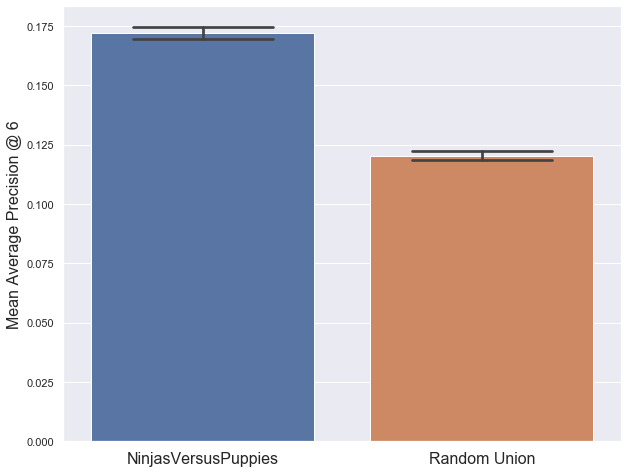

In [50]:
plt.figure(figsize=(10, 8));
#melted_results = pd.melt(results[['NvP_AP_at_3','r_u_AP_at_3','NvP_AP_at_6','r_u_AP_at_6','NvP_AP_at_12','r_u_AP_at_12']])
melted_results = pd.melt(results[['NvP_AP_at_6','r_u_AP_at_6']])
#melted_results.replace('NvP_AP_at_3','NinjasVersusPuppies@3', inplace = True)
#melted_results.replace('r_u_AP_at_3','Random Union@3', inplace = True)
melted_results.replace('NvP_AP_at_6','NinjasVersusPuppies', inplace = True)
melted_results.replace('r_u_AP_at_6','Random Union', inplace = True)
#melted_results.replace('NvP_AP_at_12','NinjasVersusPuppies@12', inplace = True)
#melted_results.replace('r_u_AP_at_12','Random Union@12', inplace = True)
plt.figure(figsize=(10,8))
sns.barplot(melted_results.variable, melted_results.value, capsize = 0.5);
plt.ylabel('Mean Average Precision @ 6', FontSize =16)
plt.xticks(FontSize = 16)
plt.xlabel('');
#plt.savefig('Barplot of MAP@6 for 20000 couples with at least 2000 movies alpha 0.0.png')

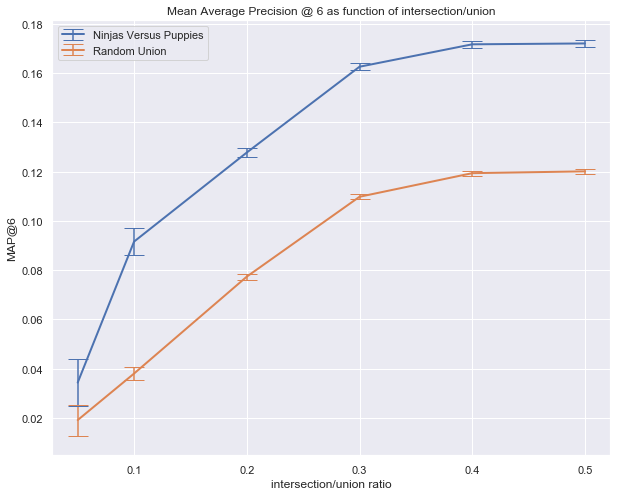

In [16]:
plt.figure(figsize=(10, 8))
plt.errorbar(x = sol.index, y = sol.MAP6_NvP, yerr= sol2.MAP6_NvP, capsize= 10, label = 'Ninjas Versus Puppies', LineWidth = 2)
plt.errorbar(x = sol.index, y = sol.MAP6_r_u, yerr= sol2.MAP6_r_u, capsize= 10, label = 'Random Union', LineWidth = 2)
plt.title('Mean Average Precision @ 6 as function of intersection/union')
plt.xlabel('intersection/union ratio')
plt.ylabel('MAP@6')
plt.legend()
plt.savefig('MAP@6 for 20000 couples with at least 2000 movies alpha 0.0.png')